__Salifort Motors__


Salifort Motors is a fictional French based alternative energy vehicle manufacturer. The business has received the results of a recent employee survey and they are wanting to analyse this data to figure out how they can increase employee retention. 

This is a capstone project part of the Google Advanced Data Analytics Certification, however additionally analysis has been done. 


__Variables and Descriptions__:

satisfaction_level: Employee-reported job satisfaction level

last_evaluation: Score of employee's last performance review

number_project: Number of projects employee contributes to

average_monthly_hours: Average number of hours employee worked per month

time_spend_company: How long the employee has been with the company (years)

work_accident: Whether or not the employee experienced an accident while at work

left: Whether or not the employee left the company

promotion_last_5years: Whether or not the employee was promoted in the last 5 years

department: The employee's department

salary: The employee's salary (U.S. dollars)


importing the data and having a first glance at what the dataset looks like 

In [1]:
#importing libraries and modules

# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# saving models
import pickle

In [2]:
#loading and the dataset 
survey_data = pd.read_csv("HR_capstone_dataset.csv")

In [3]:
#checking to see how the data looks like
survey_data.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


performing EDA and data cleaning 

In [4]:
#getting the data types for each column 
survey_data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [5]:
#checking for the number of rows and columns 
survey_data.shape

(14999, 10)

In [6]:
#renaming the columns so they are all snake_case.
survey_data.columns = survey_data.columns.str.lower()
survey_data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

here we can see there is some misspelt words so we need to fix this up

In [7]:
#renaming the columns that are misspelt 
survey_data = survey_data.rename(columns = {"average_montly_hours":"average_monthly_hours", "time_spend_company" : "tenure"})
survey_data.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [8]:
# gathering basic stats
survey_data.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


from here we can see there is no missing data as the count row has 14999 for each column which is the expected amount. However, we can double check this later on.  

In [9]:
#confirming there is no missing data 
survey_data.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [10]:
#checking for duplicates
survey_data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
14994     True
14995     True
14996     True
14997     True
14998     True
Length: 14999, dtype: bool

suggests there is duplicates so we need to investigate further

In [11]:
survey_data.tail(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
14989,0.43,0.57,2,159,3,1,1,0,technical,low
14990,0.89,0.88,5,228,5,1,1,0,support,low
14991,0.09,0.81,6,257,4,0,1,0,support,low
14992,0.40,0.48,2,155,3,0,1,0,support,low
14993,0.76,0.83,6,293,6,0,1,0,support,low
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low
14998,0.37,0.52,2,158,3,0,1,0,support,low


In [12]:
#dropping the duplicates
survey_data_1 = survey_data.drop_duplicates(keep ='first')

checking for outliers

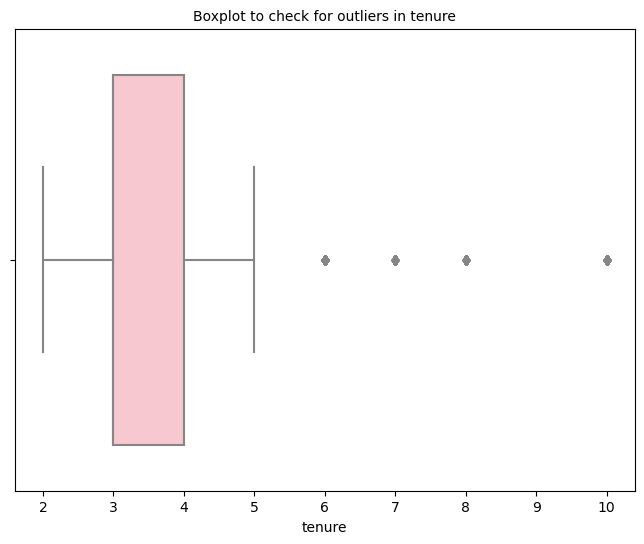

In [13]:
#checking outliers for tenture 
plt.figure(figsize = (8,6))
plt.title("Boxplot to check for outliers in tenure", fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
sns.boxplot(x=survey_data_1['tenure'], color='pink')
plt.show()

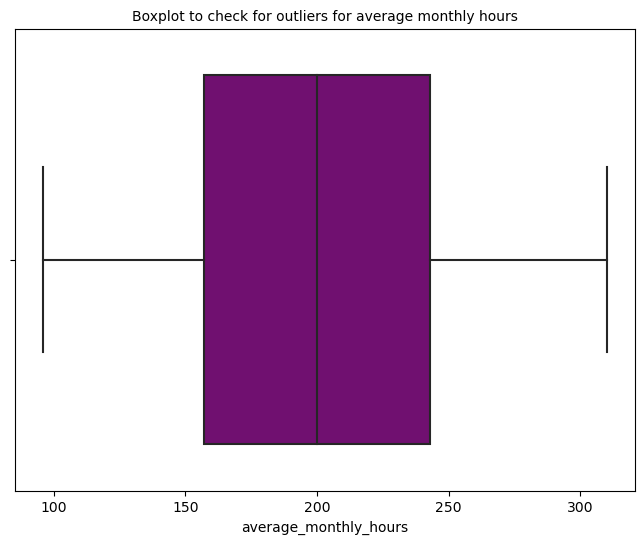

In [14]:
#checking outliers for average monthly hours
plt.figure(figsize = (8,6))
plt.title("Boxplot to check for outliers for average monthly hours", fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
sns.boxplot(x=survey_data_1['average_monthly_hours'], color='purple')
plt.show()

These boxplots suggests that there is outliers in tenure but not in average monthly hours. These were checked because these measures could affect their satisfaction level and there was wide spread of data for average monthly hours 

In [15]:
# checking for the number of rows that have outliers 

#25th percentile 
percentile25 = survey_data_1['tenure'].quantile(0.25)

#75th percentile 
percentile75 = survey_data_1['tenure'].quantile(0.75)


#iqr
iqr = percentile75 - percentile25

#upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

#filtering out for the outliers 
outliers = survey_data_1[(survey_data_1['tenure'] < lower_limit)| (survey_data_1['tenure'] > upper_limit)]

print(f"Lower limit is {lower_limit}")
print(f"Upper limit is {upper_limit}")

print(f"The number of rows that contain outliers in Tenure is {len(outliers)}")


Lower limit is 1.5
Upper limit is 5.5
The number of rows that contain outliers in Tenure is 824


doing further EDA plotting visualisation 
 

In [16]:
#checking to see how many employees left vs stayed
no_of_employees_stayed= survey_data_1['left'].value_counts()
percentage_of_employees_stayed = survey_data_1['left'].value_counts(normalize=True) * 100 

print(f"Number of people who stayed (0) vs left (1) \n {no_of_employees_stayed}\n")
print(f"Percentage of the number people who stayed (0) vs left (1) \n {percentage_of_employees_stayed}")

Number of people who stayed (0) vs left (1) 
 0    10000
1     1991
Name: left, dtype: int64

Percentage of the number people who stayed (0) vs left (1) 
 0    83.39588
1    16.60412
Name: left, dtype: float64


There was 10000 people who stayed and 1991 who left.
83.4% of surveyees stayed at the company whereas 16.6% had left the company. 

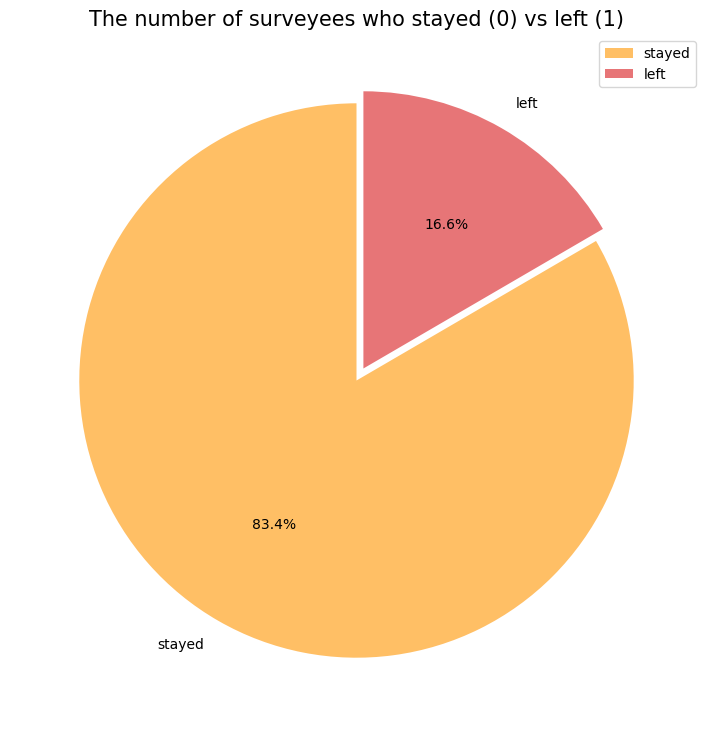

In [17]:
#creating pie chart for the number of people who stayed vs left

plt.figure(figsize = (12,9))
labels = ['stayed', 'left']
colours = ['#ffbf65','#e77577']
plt.pie(no_of_employees_stayed, colors= colours, labels=labels, autopct='%.1f%%',startangle =90, explode=(0,0.05) )
plt.title("The number of surveyees who stayed (0) vs left (1)", fontsize = 15)
plt.legend()
plt.axis()
plt.show()

to check the correlation between the variables in the data we can plot a correlation heatmap

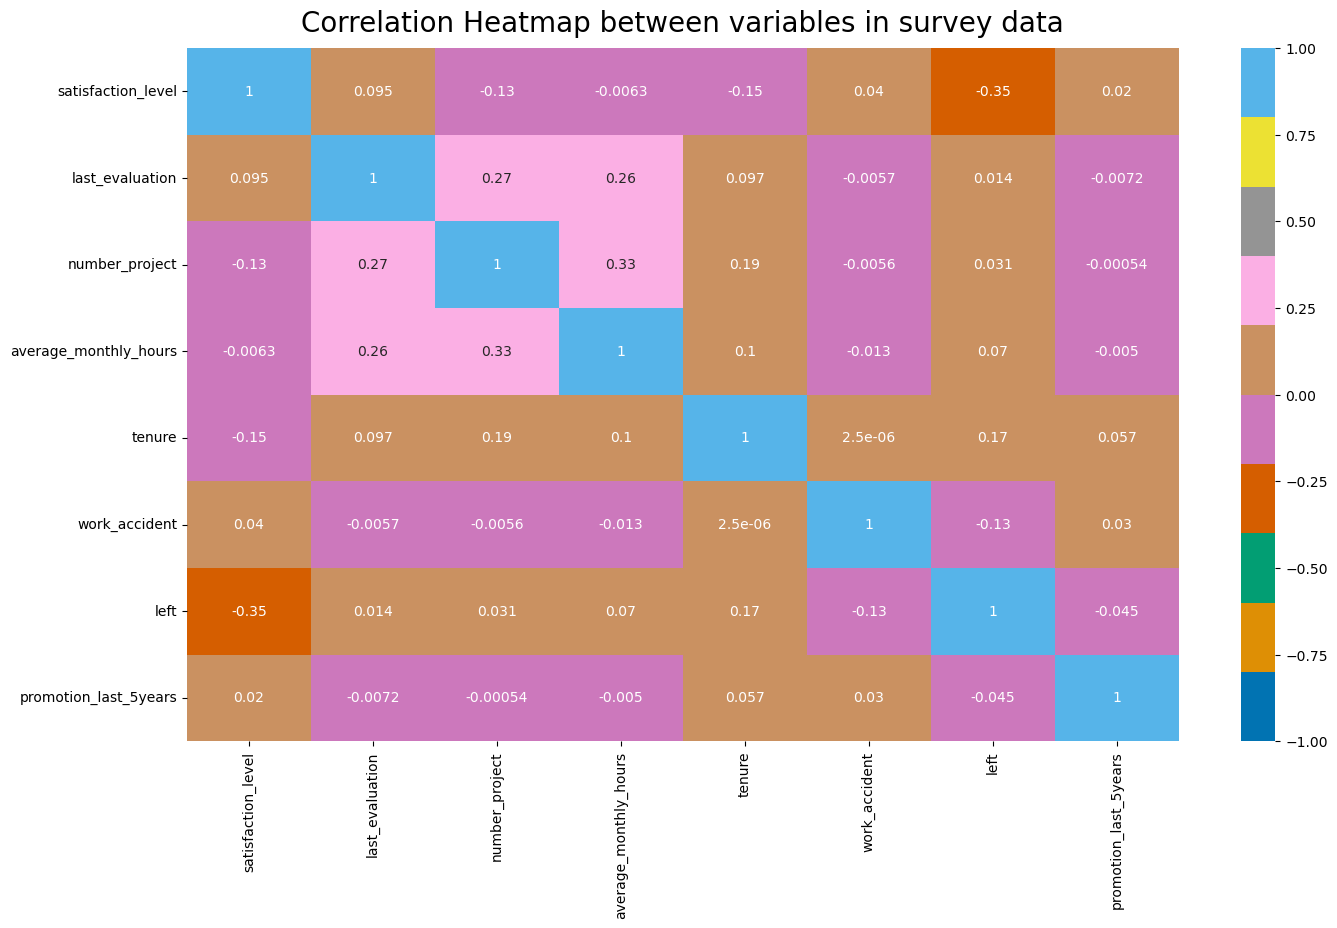

In [18]:
#correlation heatmap 
plt.figure(figsize=(16, 9))
data = survey_data_1.copy()
data = data.drop(columns=['department', 'salary']) #dropping these columns as we need numerical data for correlation heatmap
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("colorblind", as_cmap=True))
heatmap.set_title('Correlation Heatmap between variables in survey data', fontdict={'fontsize':20}, pad= 12);
plt.show()


This heatmap suggests there is some correlation between the number of projects and the average monthly hours. Additionally, some correlation between tenure and people who have stayed vs left, some correlation between tenure and number of projects. Furthermore, there is some correlation between the last evaluation, satisfaction level, number of projects, average monthly hours, tenure and whether they have stayed or left. 

Despite all this correlation since we are exploring how we can increase __employee retention__ we should focus on the investigating further between the correlation of those who left with tenure, average monthly hours, number of projects and last evaluation. 

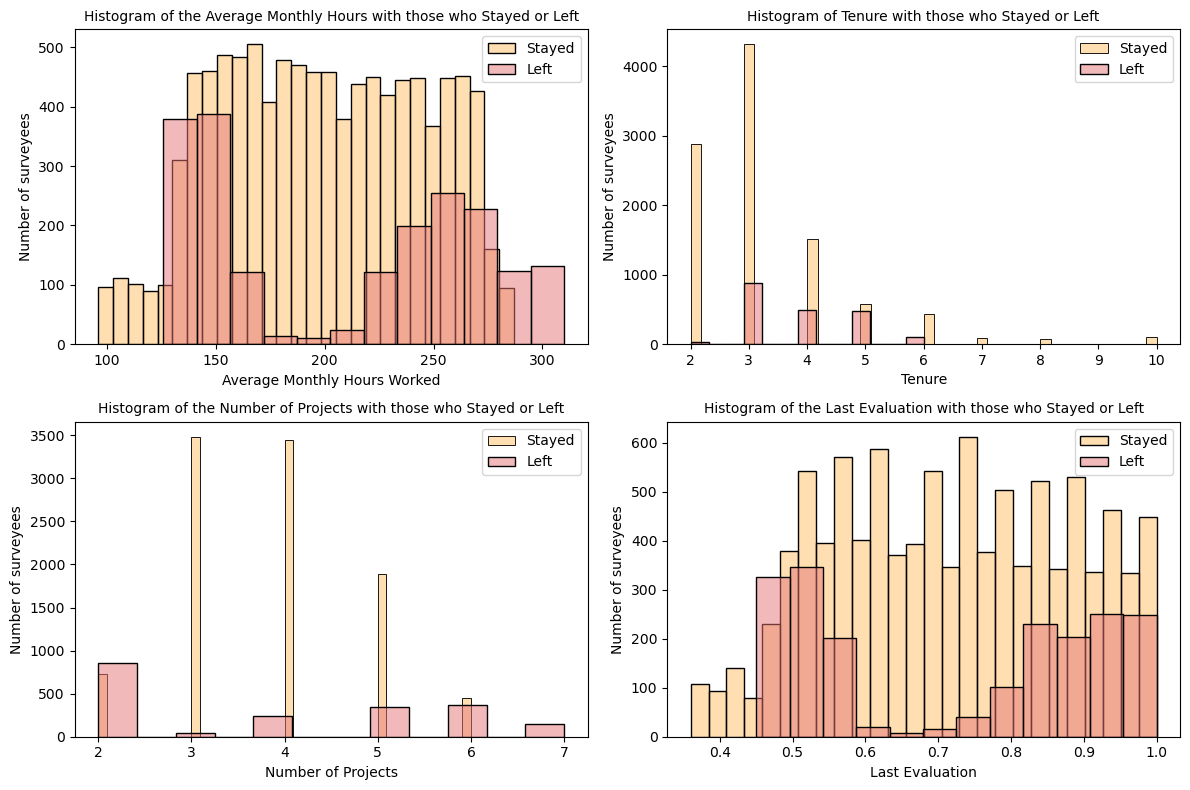

In [19]:
#histogram on the number of those who left with the average monthly hours they worked 
plt.figure(figsize = (12,8))
plt.subplot(2,2,1)
filter_stayed = survey_data_1[survey_data_1['left'] == 0]
filter_left = survey_data_1[survey_data_1['left'] == 1]

sns.histplot(filter_stayed['average_monthly_hours'], color= '#ffbf65', label = "Stayed", alpha = 0.5 )
sns.histplot(filter_left['average_monthly_hours'], color= '#e77577', label = "Left", alpha = 0.5)
plt.xlabel("Average Monthly Hours Worked")
plt.ylabel("Number of surveyees")
plt.title("Histogram of the Average Monthly Hours with those who Stayed or Left", fontsize = 10 )
plt.legend()

#histogram on the number of those who left with tenure 
plt.subplot(2,2,2)

sns.histplot(filter_stayed['tenure'], color= '#ffbf65', label = "Stayed", alpha = 0.5 )
sns.histplot(filter_left['tenure'], color= '#e77577', label = "Left", alpha = 0.5)
plt.xlabel("Tenure")
plt.ylabel("Number of surveyees")
plt.title("Histogram of Tenure with those who Stayed or Left", fontsize = 10)
plt.legend()

#histogram on the number of those who left with number of projects 
plt.subplot(2,2,3)

sns.histplot(filter_stayed['number_project'], color= '#ffbf65', label = "Stayed", alpha = 0.5 )
sns.histplot(filter_left['number_project'], color= '#e77577', label = "Left", alpha = 0.5)
plt.xlabel("Number of Projects")
plt.ylabel("Number of surveyees")
plt.title("Histogram of the Number of Projects with those who Stayed or Left", fontsize = 10)
plt.legend()

#histogram on the number of those who left with last evaluation
plt.subplot(2,2,4)

sns.histplot(filter_stayed['last_evaluation'], color= '#ffbf65', label = "Stayed", alpha = 0.5 )
sns.histplot(filter_left['last_evaluation'], color= '#e77577', label = "Left", alpha = 0.5)
plt.xlabel("Last Evaluation")
plt.ylabel("Number of surveyees")
plt.title("Histogram of the Last Evaluation with those who Stayed or Left", fontsize = 10)
plt.legend()

plt.tight_layout()
plt.show()



NOTE: The numbers used here are rough and based on the graph. Exact numbers will be calculated below. 

__observations:__
For the histogram for average monthly hours the graph displays that around the 275h mark many employees left the company. Additionally, many employees who worked fewer hours between approx 125h to 170h also had left the company. A normal individual working a 9-5 would be working approx 160h a week which is where majority of the employees had left the company. This suggests that employees who work for longer hours and those who did work a typical 40h work week were more likely to leave the company. 

For the histogram for the number of projects employees did a similar pattern aroused. Those who worked 2 projects, more people had left the company. Additionally, those who did on 7 projects did leave the company. Whereas those who worked 3 - 5 projects, more employees stayed at the company. 

For the histogram comparing tenure with those who stayed or left, many employees who worked for 2 years stayed at the company, whereas those who worked 3-4 years some did leave the company but it isnt as much as the 5 mark where nearly half of the employees working for 5 years left the company. Additionally more employees who worked for 6-10 years stayed at the company than those who left.

Finally, for the graph showcasing the last evaluation many employees left where the evaluation score was between 0.45- 0.6. However, many employees also left despite been given an evaluation score between 0.8-1.0. Additionally, many employees who gave a lower evaluation (less than 0.45) stayed at the company despite a low evaluation score. 

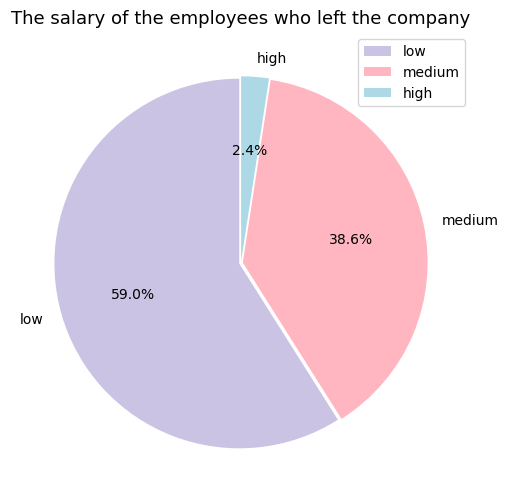

In [20]:
#creating a pie chart to see the salary of the employees who left 

plt.figure(figsize = (8,6))
salary_left = filter_left['salary'].value_counts(normalize=True)

explode = (0.01, 0.01, 0.01)
labels = filter_left['salary'].unique()
colours = ['#CBC3E3','#ffb6c1', '#ADD8E6']
plt.pie(salary_left, colors= colours, labels=labels, autopct='%.1f%%', startangle =90, explode = explode)
plt.title("The salary of the employees who left the company", fontsize = 13)
plt.legend()
plt.axis()
plt.show()


from this chart we can see that majority of the employees who left had a low salary

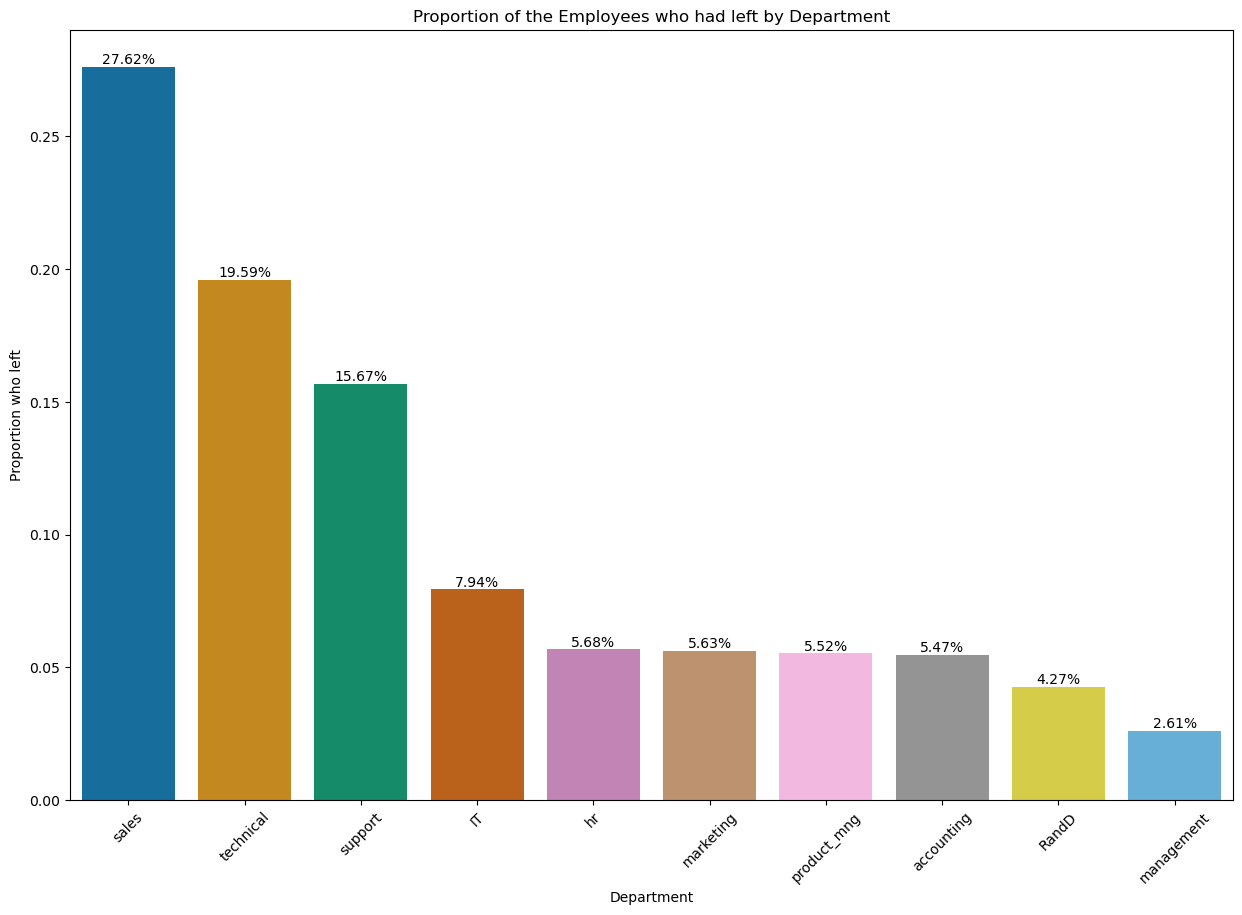

In [21]:
plt.figure(figsize=(15, 10))

department_left = filter_left['department'].value_counts(normalize=True)
department_left = department_left.sort_values(ascending=False)

colours = sns.color_palette("colorblind", len(department_left))
barplot = sns.barplot(x=department_left.index, y=department_left.values, palette=colours)

plt.title("Proportion of the Employees who had left by Department")
plt.xlabel("Department")
plt.ylabel("Proportion who left")

# Adding labels 
for i, value in enumerate(department_left.values):
    barplot.text(i, value, f'{value:.2%}', ha='center', va='bottom')

plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.axis()
plt.show()

here we can see 27.62% of those who left were in the sales department 

In [22]:
# getting the numbers who of employees who stayed vs left based upon salary
df_stay_left_salary = survey_data_1[['salary', 'left']]
df_stay_left_salary.value_counts()

salary  left
low     0       4566
medium  0       4492
low     1       1174
high    0        942
medium  1        769
high    1         48
dtype: int64

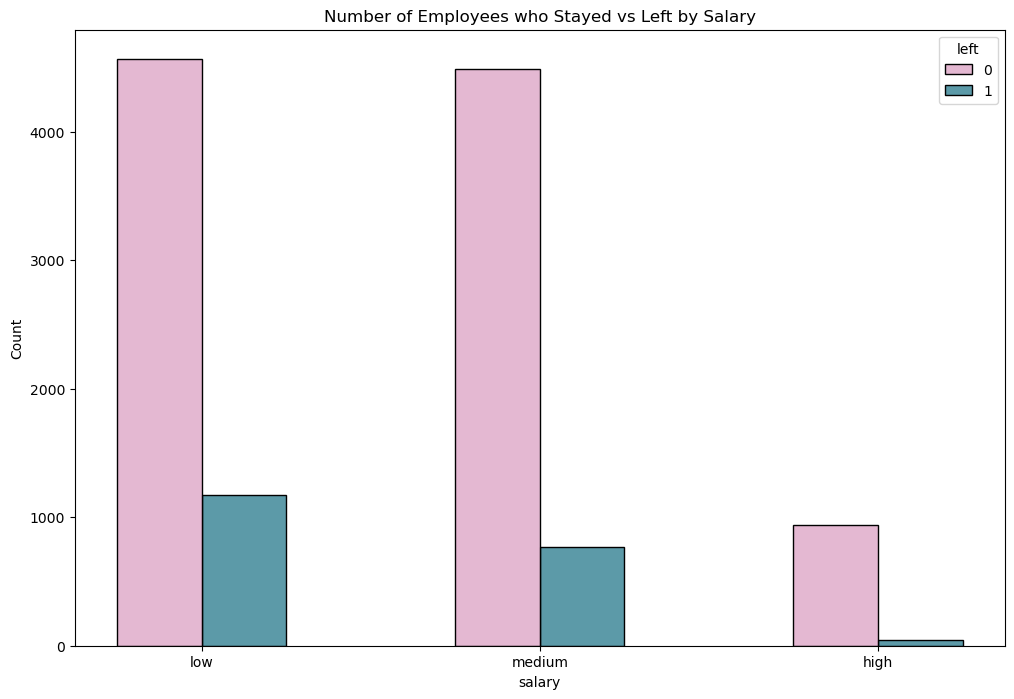

In [23]:
#creating side by side plot to see the proportion of those who left vs stayed based upon salary 
plt.figure(figsize = (12,8))
colours = ['#dca0c3', '#26788b']

sns.histplot(data = survey_data_1, x='salary', hue = 'left', discrete=1, hue_order=[0,1], multiple = 'dodge', shrink = 0.5, palette=colours)
plt.title("Number of Employees who Stayed vs Left by Salary")
plt.show()

alot of employees still stayed at the company even though they had a low salary. 

In [24]:
# getting the numbers who of employees who stayed vs left based upon department
df_stay_left_department = survey_data_1[['department', 'left']]
df_stay_left_department.value_counts()

department   left
sales        0       2689
technical    0       1854
support      0       1509
IT           0        818
RandD        0        609
product_mng  0        576
marketing    0        561
sales        1        550
accounting   0        512
hr           0        488
technical    1        390
management   0        384
support      1        312
IT           1        158
hr           1        113
marketing    1        112
product_mng  1        110
accounting   1        109
RandD        1         85
management   1         52
dtype: int64

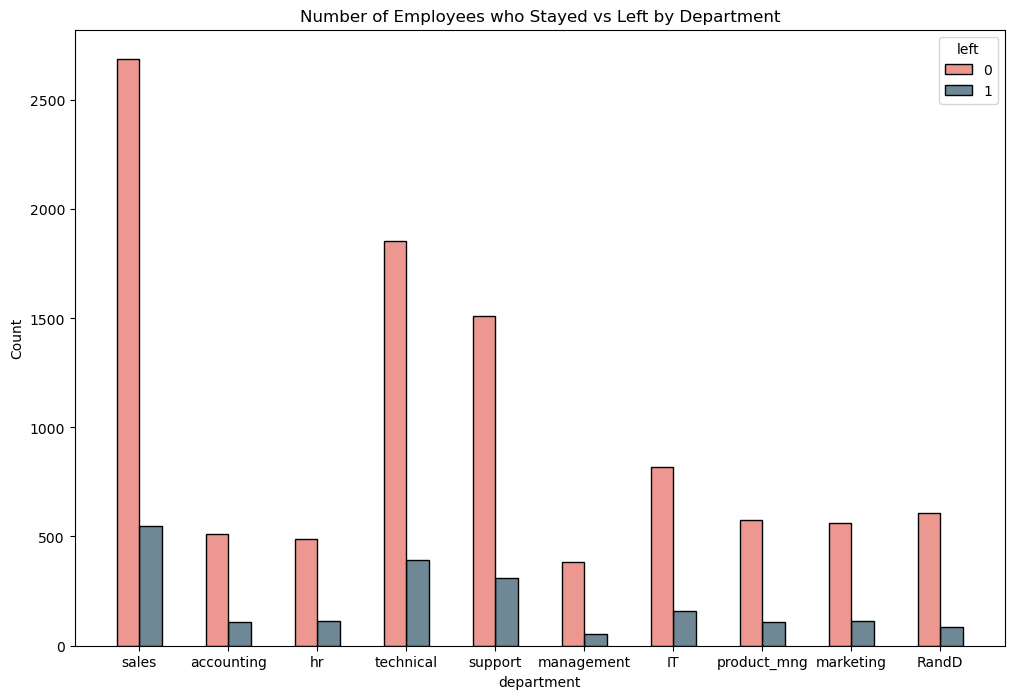

In [25]:
#creating side by side plot to see the proportion of those who left vs stayed based upon department 
plt.figure(figsize = (12,8))
colours = ['#e6756b', '#3e6272']


sns.histplot(data = survey_data_1, x='department', hue = 'left', discrete=1, hue_order=[0,1], multiple = 'dodge', shrink = 0.5, palette=colours)
plt.title("Number of Employees who Stayed vs Left by Department")
plt.show()

In [26]:
#creating a scatterplot for the average monthly hours vs satisfaction level for the employees who stayed vs left 

plt.figure(figsize = (15,8))

colours = {0:'#e6756b', 1:'#3e6272' }
sns.scatterplot(x = 'satisfaction_level', y= 'average_monthly_hours', hue = 'left', data = survey_data_1, palette=colours, alpha = 0.5 )

plt.title("Average Monthly Hours worked vs Satisfaction level for employees who left and stayed", fontsize = 15)
plt.xlabel("Satisfaction Level")
plt.ylabel("Average Monthly Hours")
plt.axis()
plt.legend(title = 'Employees', labels = ['Stayed - 0', 'Left - 1'])
plt.show()

We can see that alot of employees who gave a low satisfaction level and were working high average monthly hours left the company. Additionally, another group of employees despite having a lower number of hours also seemed to be dissatisfied by their work. 

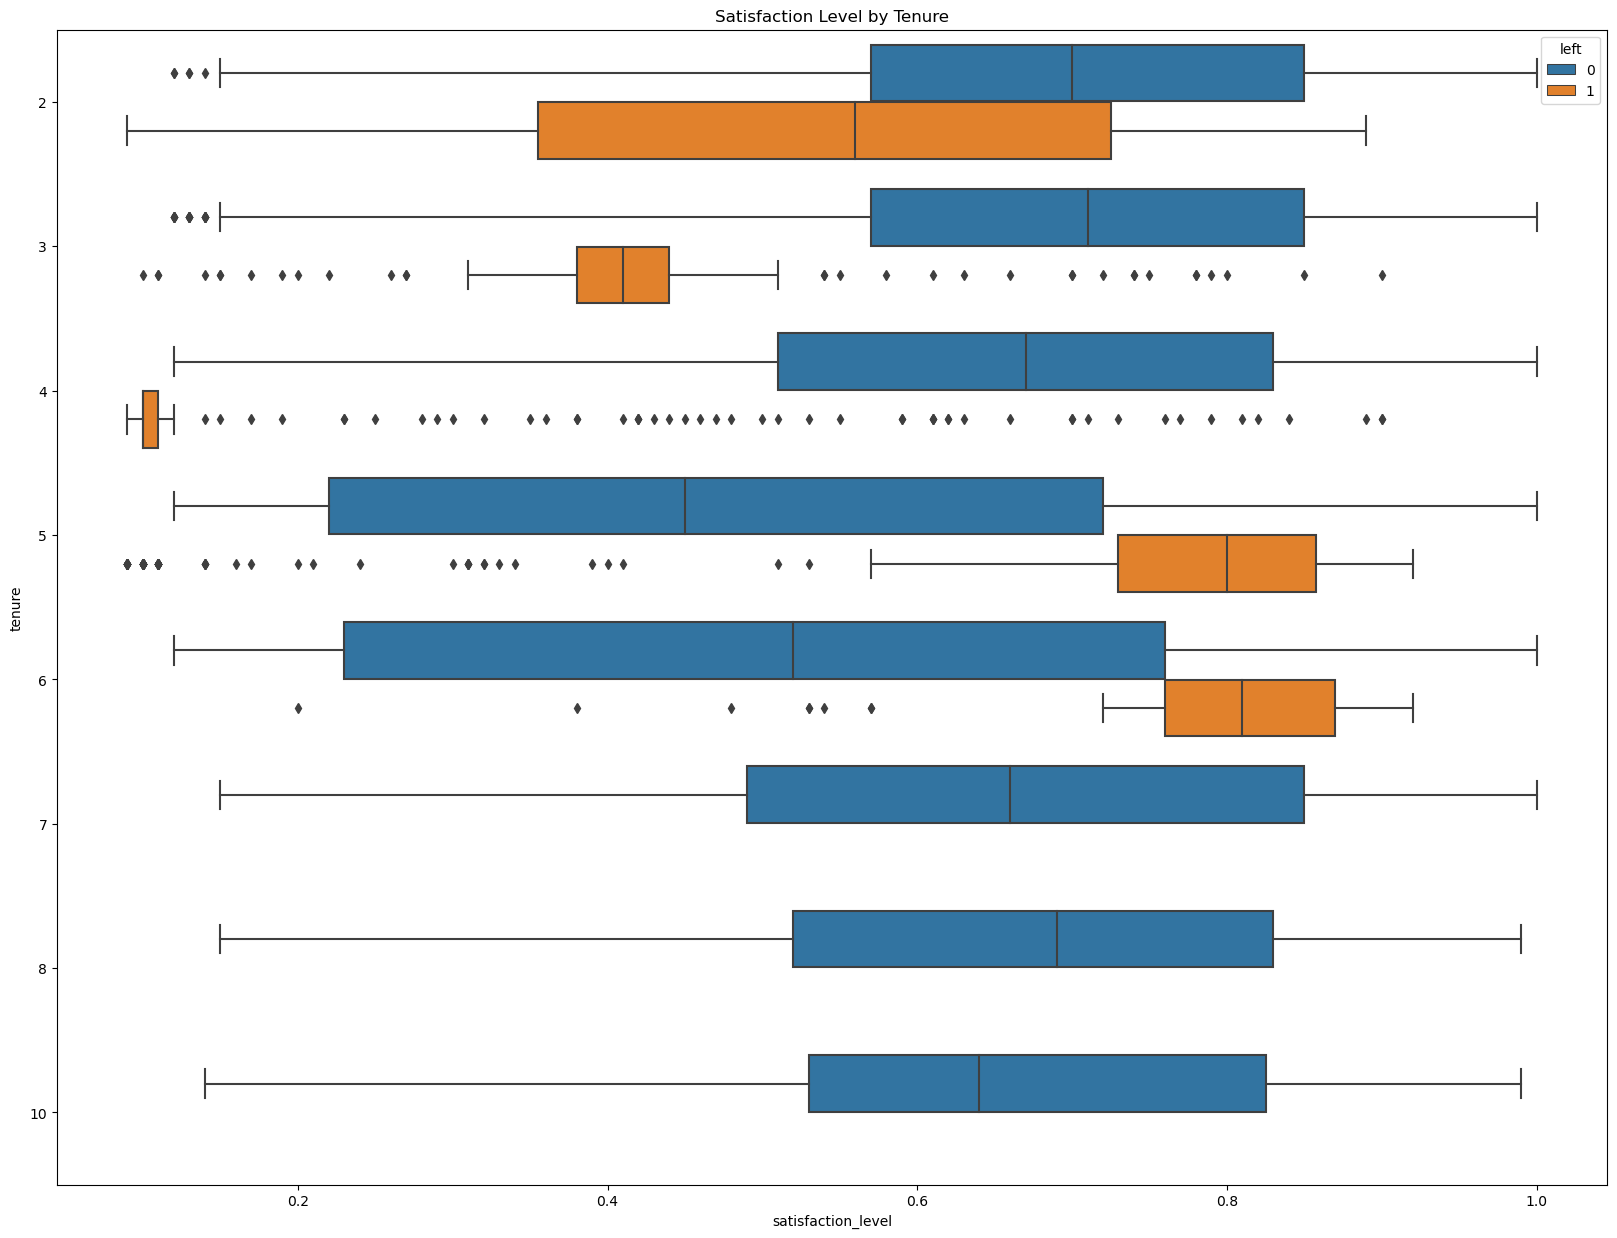

In [27]:
# boxplot for satisfaction level by tenure
plt.figure(figsize=(20,15))
sns.boxplot(data = survey_data_1, x = 'satisfaction_level', y='tenure', hue = 'left', orient = 'h')
plt.title("Satisfaction Level by Tenure")
plt.axis()
plt.show()


Those who worked for a longer period of time didn't leave. Those who worked 2-3 years had a similar satisfaction with those who woked 7-10 years. Whereas those who worked 4 years and then left had a very low satisfaction level. 

In [28]:
#further investigation of those employees who left or stayed and their mean and median satisfaction score

survey_data_1.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])

,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


those who stayed on average had a higher satisfaction level than those who left

In [29]:
survey_data_1.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


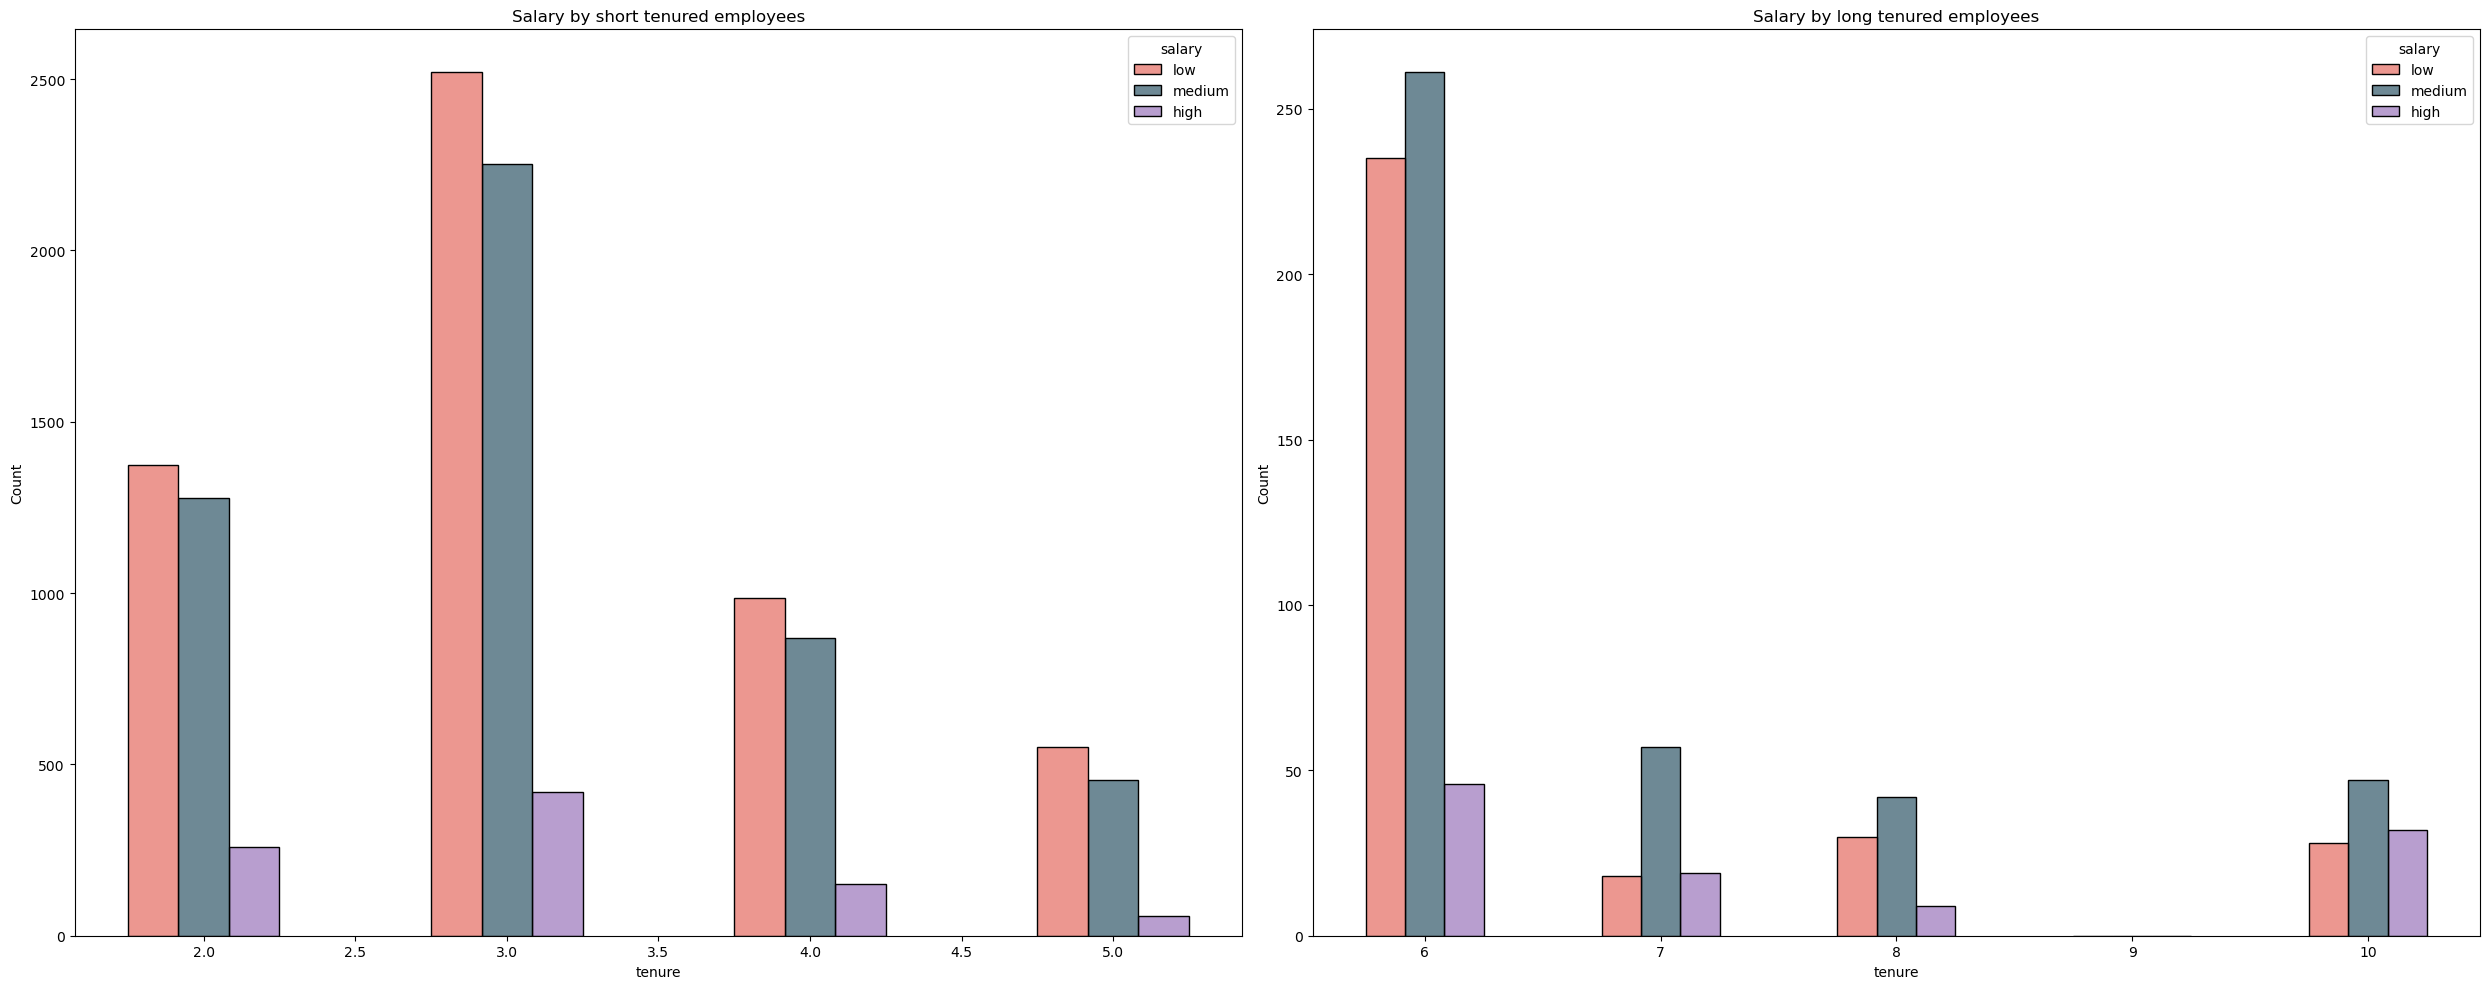

In [30]:
#salary and tenure
plt.figure(figsize=(25,10))

short_tenure = survey_data_1[survey_data_1['tenure'] < 6]
long_tenure = survey_data_1[survey_data_1['tenure'] > 5]

plt.subplot(1,2,1)
colours = ['#e6756b', '#3e6272', '#a07ec0']

sns.histplot(data = short_tenure, x='tenure', hue = 'salary', discrete=1, hue_order=['low', 'medium', 'high'], multiple = 'dodge',shrink = 0.5, palette=colours)
plt.title("Salary by short tenured employees")


plt.subplot(1,2,2)
sns.histplot(data = long_tenure, x='tenure', hue = 'salary', discrete=1, hue_order=['low', 'medium', 'high'], multiple = 'dodge',shrink = 0.5, palette=colours)
plt.title("Salary by long tenured employees")
plt.axis()
plt.tight_layout()
plt.show()

Employees who have worked for more than 5 years are classified as long-tenured employees and less than 5 years are short-tenured employees. 

Based on the graph those employees classified as short-tenured, more employees had a low salary range vs those long-tenured where more people had a medium salary range. Which suggests a pay rise. 

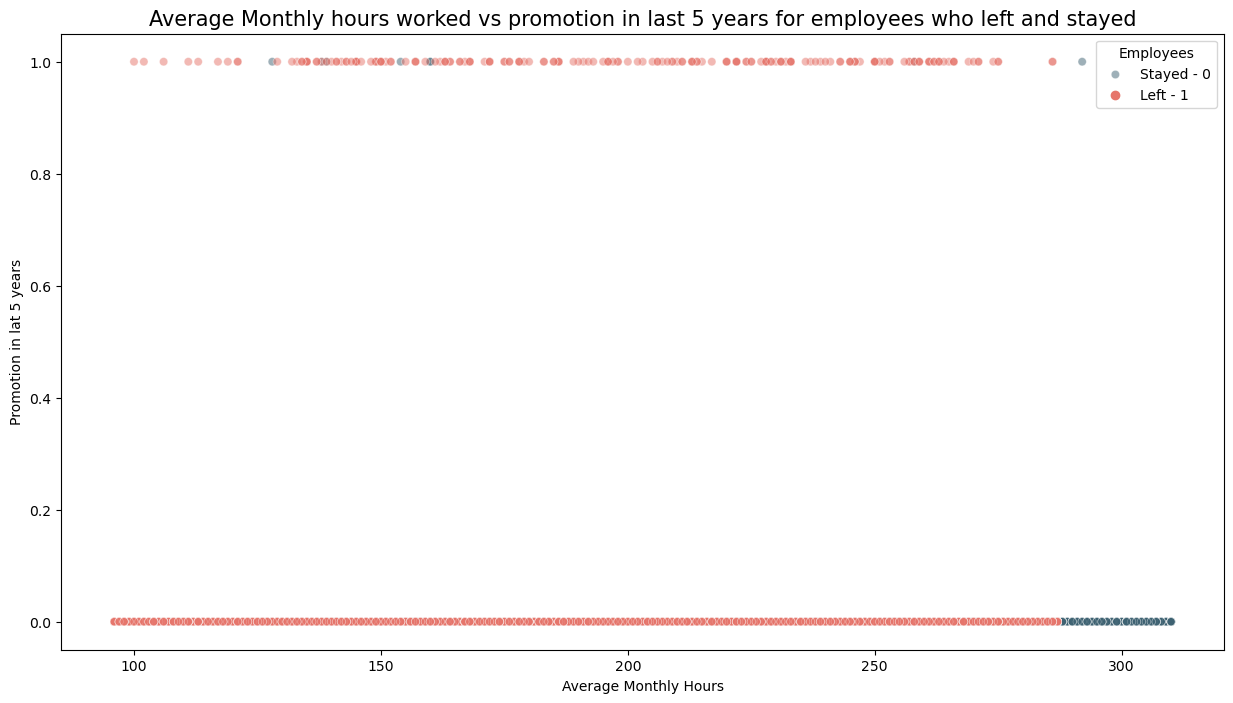

In [31]:
#promotion in the last years and the average monthly hours 

plt.figure(figsize = (15,8))

colours = {0:'#e6756b', 1:'#3e6272' }
sns.scatterplot(x = 'average_monthly_hours', y= 'promotion_last_5years', hue = 'left', data = survey_data_1, palette=colours, alpha = 0.5 )

plt.title("Average Monthly hours worked vs promotion in last 5 years for employees who left and stayed", fontsize = 15)
plt.xlabel("Average Monthly Hours")
plt.ylabel("Promotion in lat 5 years")
plt.axis()
plt.legend(title = 'Employees', labels = ['Stayed - 0', 'Left - 1'])
plt.show()


The graph shows that not many employees were promoted in the last 5 years and those employees who did work long hours didn't get promoted

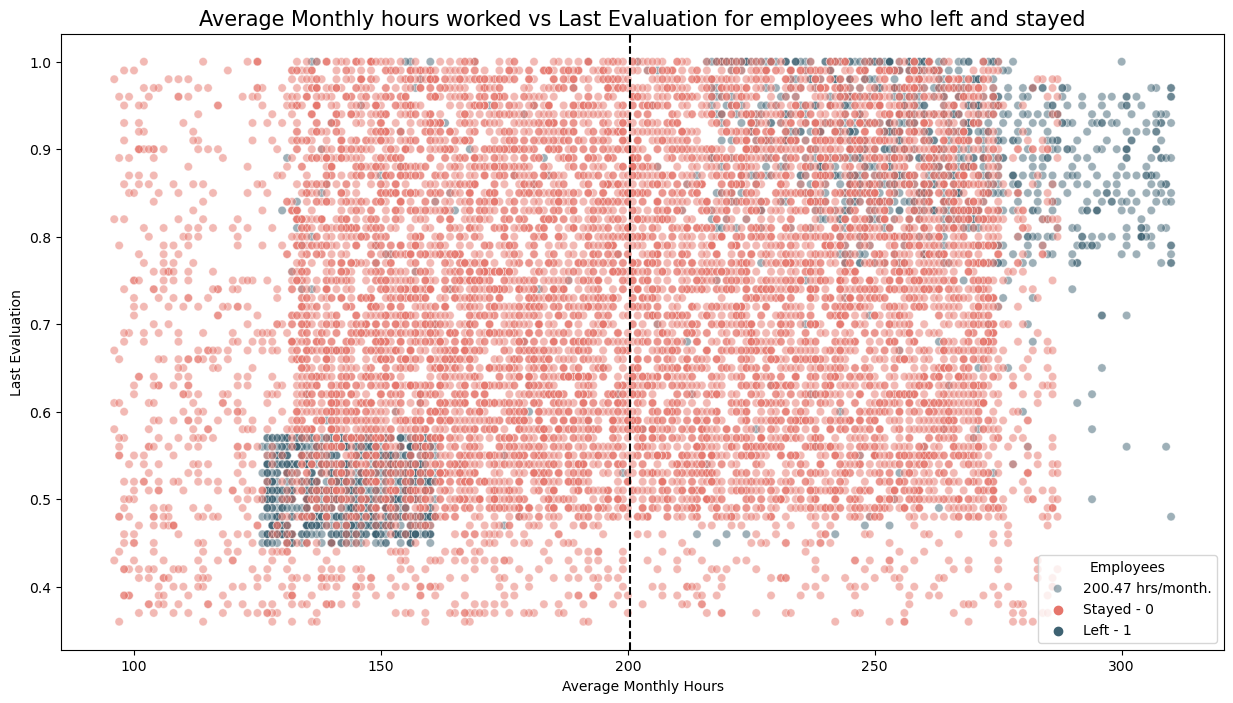

In [32]:
#last evaluation and the average monthly hours 

plt.figure(figsize = (15,8))

colours = {0:'#e6756b', 1:'#3e6272' }
sns.scatterplot(x = 'average_monthly_hours', y= 'last_evaluation', hue = 'left', data = survey_data_1, palette=colours, alpha = 0.5 )

plt.title("Average Monthly hours worked vs Last Evaluation for employees who left and stayed", fontsize = 15)
plt.xlabel("Average Monthly Hours")
plt.ylabel("Last Evaluation")
plt.axis()
plt.axvline(x=200.47, color='black', label='200.47 hrs/month.', ls='--')
plt.legend(title = 'Employees', labels = ['200.47 hrs/month.','Stayed - 0', 'Left - 1'])
plt.show()


There is a portion of employees who worked fewer hours than the average and had been reported with a lower last_evalation score and those employees had left the company. On the other hand there are employees who worked for longer hours and despite having a good last_evaluation score they also decided to leave the company

modeling 


In [33]:
survey_data_model = survey_data_1.copy()

#checking the number of occurences in each class based on whether the employees has left or not

balance = survey_data_model['left'].value_counts()

balance_percentage = balance / len(survey_data_model) * 100
print(f"Balance: \n {balance}")
print(f"\nData Balance Percentage: \n {balance_percentage}")

Balance: 
 0    10000
1     1991
Name: left, dtype: int64

Data Balance Percentage: 
 0    83.39588
1    16.60412
Name: left, dtype: float64


There is a slight imbalance in the data

In [34]:
#one hot encoding
survey_data_model = pd.get_dummies(survey_data_model, columns = ['department'], drop_first = True)

#ordinal encoding 
salary_mapping = {'low': 0, 'medium': 1, 'high' : 2}
survey_data_model['salary'] = survey_data_model['salary'].map(salary_mapping)

survey_data_model.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


In [35]:
#splitting the data 

X = survey_data_model.copy()
X = X.drop(['left'], axis = 1)

y = survey_data_model['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

Using Random Forest


In [40]:
#parameters
%time

rf = RandomForestClassifier(random_state = 0)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf_model = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

#fitting the model 
rf_model.fit(X_train, y_train)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy', 'roc_auc', 'precision', 'f1', 'recall'})

In [41]:
#assign path
path = '/Users/ankitachoudhary/Documents/ankita/side projects/salifort-motors-capstone-project'

#pickle model 
with open(path + 'rf_model_p.pickle', 'wb') as to_write:
    pickle.dump(rf_model, to_write)


#open model
with open(path + 'rf_model_p.pickle', 'rb') as to_read:
    rf_model = pickle.load(to_read)


In [42]:
#find the parameters that will give us the best performing model 
grid_search_best_params = rf_model.best_params_
print(grid_search_best_params)

{'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}


In [43]:
#check the best score given
grid_search_best_score = rf_model.best_score_
print(grid_search_best_score)

0.9803970236985848


In [47]:
#use the best parameters and apply it to the model
rf_model_best_para_applied = RandomForestClassifier(n_estimators = 500 , max_depth = 5 , min_samples_leaf = 1, min_samples_split = 4, max_features = 1.0,max_samples = 0.7, random_state = 0)

#fitting it to the model
rf_model_best_para_applied.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=1.0, max_samples=0.7,
                       min_samples_split=4, n_estimators=500, random_state=0)

In [48]:
#predict using test set 
y_predictions_rf = rf_model_best_para_applied.predict(X_test)

In [57]:
#get the evaluation scores 
accuracy_rf = accuracy_score(y_test, y_predictions_rf)
recall_rf = recall_score(y_test, y_predictions_rf)
precision_rf = precision_score(y_test, y_predictions_rf)
f1_rf = f1_score(y_test, y_predictions_rf)
auc_rf = roc_auc_score(y_test, y_predictions_rf)

model_name_rf = "Random Forest"  

print(f"Model: {model_name_rf}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC: {auc_rf:.4f}")


Model: Random Forest
Accuracy: 0.9810
Precision: 0.9642
F1 Score: 0.9414
AUC: 0.9564


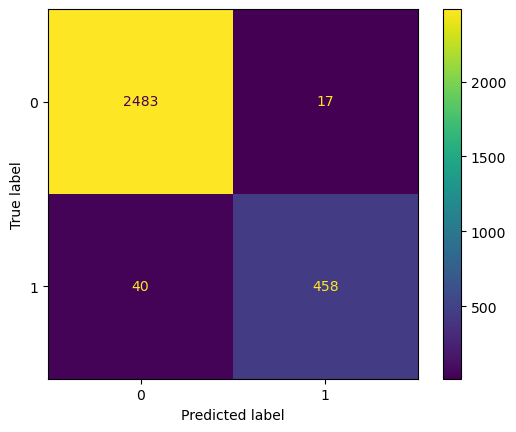

In [59]:
#plot confusion matrix
preds = rf_model.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf_model.classes_)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf_model.classes_)
display.plot(values_format='');


Here the model correctly predicted that 2483 employees stayed and that 458 employees left. 

Feature engineering -  
It is a possibility that there is some data leak because there is high evaluation results. 
The average monthly hour column could be contributing to this as individuals who have decided to quit may decide to work shorter hours. Here we are creating a new variable to see if the person has overworked. We will also drop the satisfaction level. 


In [75]:
survey_data_2 = survey_data_model.drop(columns = {'satisfaction_level'})
survey_data_2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


In [76]:
survey_data_2['overworked'] = survey_data_2['average_monthly_hours']
print(f"{survey_data_2['overworked'].min()}, {survey_data_2['overworked'].max()}")

96, 310


Someone who works 40h a week (8 hours a day for 5 days) for 52 weeks in a year works on average 173.33 h a month. So in this scenario those who work over 175 h are overworked. As we have not been given any additional info on how many days off employees get in a year we will assume they work for the 52 weeks.  

In [77]:
survey_data_2['overworked'] = (survey_data_2['overworked'] > 175).astype(int)

In [78]:
survey_data_2 = survey_data_2.drop(columns = {'average_monthly_hours'})
survey_data_2.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,1,0,0,0


repeating the random forest model for the second time

In [80]:
#splitting the data 

X = survey_data_2.copy()
X = X.drop(['left'], axis = 1)

y = survey_data_2['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [81]:
#parameters

%time
rf2 = RandomForestClassifier(random_state = 0)

cv_params_2 = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf_model_2 = GridSearchCV(rf2, cv_params_2, scoring=scoring, cv=4, refit='roc_auc')

#fitting the model 
rf_model_2.fit(X_train, y_train)


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 176 µs


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy', 'roc_auc', 'precision', 'f1', 'recall'})

In [82]:
#assign path
path = '/Users/ankitachoudhary/Documents/ankita/side projects/salifort-motors-capstone-project'

#pickle model 
with open(path + 'rf_model_2_p.pickle', 'wb') as to_write:
    pickle.dump(rf_model, to_write)


#open model
with open(path + 'rf_model_2_p.pickle', 'rb') as to_read:
    rf_model_2 = pickle.load(to_read)

In [83]:
#find the parameters that will give us the best performing model 
grid_search_best_params_2 = rf_model_2.best_params_
print(grid_search_best_params_2)

{'max_depth': 5, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}


In [84]:
#check the best score given
grid_search_best_score_2 = rf_model_2.best_score_
print(grid_search_best_score_2)

0.9803970236985848


In [89]:
#use the best parameters and apply it to the model
rf_model_best_para_applied_2 = RandomForestClassifier(n_estimators = 500 , max_depth = 5 , min_samples_leaf = 1, min_samples_split = 4, max_features = 1.0,max_samples = 0.7, random_state = 0)

#fitting it to the model
rf_model_best_para_applied_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=1.0, max_samples=0.7,
                       min_samples_split=4, n_estimators=500, random_state=0)

In [90]:
#predict using test set 
y_predictions_rf_2 = rf_model_best_para_applied_2.predict(X_test)

In [91]:
#get the evaluation scores 
accuracy_rf_2 = accuracy_score(y_test, y_predictions_rf)
recall_rf_2 = recall_score(y_test, y_predictions_rf)
precision_rf_2 = precision_score(y_test, y_predictions_rf)
f1_rf_2 = f1_score(y_test, y_predictions_rf)
auc_rf_2 = roc_auc_score(y_test, y_predictions_rf)

model_name_rf_2 = "Random Forest Round 2"  

print(f"Model: {model_name_rf}")
print(f"Accuracy: {accuracy_rf_2:.4f}")
print(f"Precision: {precision_rf_2:.4f}")
print(f"F1 Score: {f1_rf_2:.4f}")
print(f"AUC: {auc_rf_2:.4f}")


Model: Random Forest
Accuracy: 0.9810
Precision: 0.9642
F1 Score: 0.9414
AUC: 0.9564


We got very similar results as before

__feature importance__

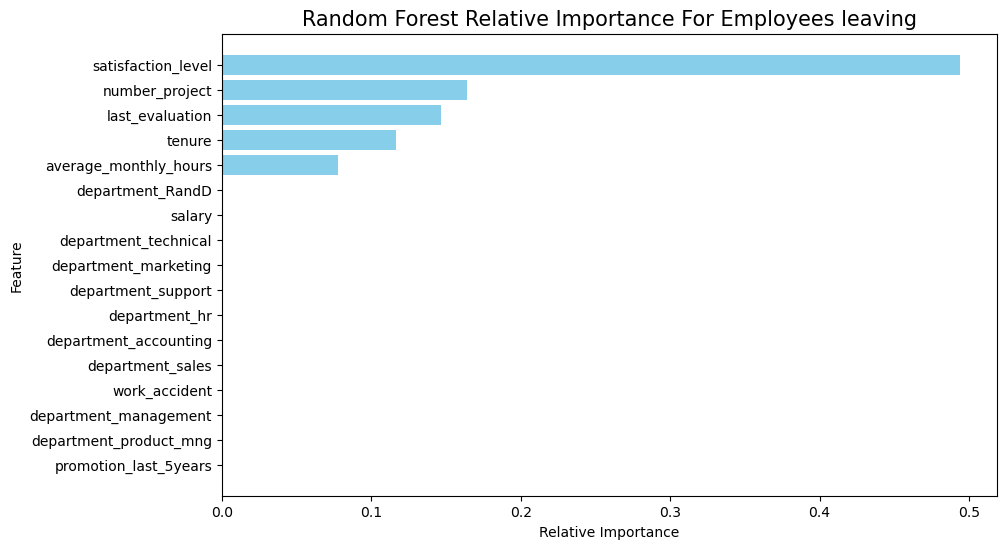

In [117]:
features = survey_data_model.drop(columns=['left']).columns
importances = rf_model.best_estimator_.feature_importances_

#sorting the features based upon importances
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Random Forest Relative Importance For Employees leaving', fontsize = 15)
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

Here we can see that satisfaction level, number of projects, last evaluation, tenure and average monthly hours are the more important features. This can be checked with the heatmap as well which showcased a similar result. 